# Predicting Emotion in Twitter Sentiment Analysis - Machine Learning part 2

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.metrics import specificity_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from time import time

In [5]:
data = pd.read_csv('../projects/cleanedtweets.csv')

In [6]:
data.head()

,label,text,text_emoticon,text_clean,text_pre,text_token,text_str,text_stem,text_lemm,is_equal
0,1,I LOVE @Health4UandPets u guys r the best!!,I LOVE @Health4UandPets u guys r the best!!,i love u guys r the best,i love u guys r the best,"['love', 'u', 'guys', 'r', 'best']",love u guys r best,love guys best,love u guys r best,True
1,1,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight c...,im meeting up with one of my besides tonight c...,"['im', 'meeting', 'one', 'besides', 'tonight',...",im meeting one besides tonight cant wait girl ...,meeting one besides tonight cant wait girl talk,im meeting one besides tonight cant wait girl ...,True
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S...","@DaRealSunisaKim Thanks for the Twitter add, S...",thanks for the twitter add sunisa i got to me...,thanks for the twitter add punish i got to mee...,"['thanks', 'twitter', 'add', 'punish', 'got', ...",thanks twitter add punish got meet hin show dc...,thanks twitter add punish got meet hin show ar...,thanks twitter add punish got meet hin show dc...,True
3,1,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...,"['sick', 'really', 'cheap', 'hurts', 'much', '...",sick really cheap hurts much eat real food plu...,sick really cheap hurts much eat real food plu...,sick really cheap hurts much eat real food plu...,True
4,1,@LovesBrooklyn2 he has that effect on everyone,@LovesBrooklyn2 he has that effect on everyone,he has that effect on everyone,he has that effect on everyone,"['effect', 'everyone']",effect everyone,effect everyone,effect everyone,True


In [4]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          50000 non-null  int64 
 1   text           50000 non-null  object
 2   text_emoticon  50000 non-null  object
 3   text_clean     49908 non-null  object
 4   text_pre       49893 non-null  object
 5   text_token     50000 non-null  object
 6   text_str       49746 non-null  object
 7   text_stem      49682 non-null  object
 8   text_lemm      49746 non-null  object
 9   is_equal       50000 non-null  bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 3.5+ MB


In [7]:
X = data.text_stem
y = data.label

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [9]:
# show summary report for classification report 
def show_summary_report(actual, prediction, probabilities):
    
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)
        
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' 
          % accuracy_score(actual, prediction))
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' 
          % precision_score(actual, prediction))
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0' 
          % recall_score(actual, prediction))
    print('ROC AUC : %.4f      Best: 1, Worst: <0.5' 
          % roc_auc_score(actual, prediction))
    print('-' * 107)
        
    # confusion matrix
    mat = confusion_matrix(actual, prediction)
    
    # precision/recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
        
    # compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)
        
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    fig.subplots_adjust(left=0.02, right = 0.98, wspace=0.2)
        
    # confusion matrix
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', 
                cbar=False, cmap='Blues', ax=ax[0])
        
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # precision/recall
    step_kwargs= {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color = 'b', **step_kwargs)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel(['Recall'])
    ax[1].set_ylabel(['Precision'])
    ax[1].set_title(['2-class Precision-Recall curve'])
        
    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2,
                  label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel(['False Positive Rate'])
    ax[2].set_ylabel(['True Positive Rate'])
    ax[2].set_title(['Receiver Operating Characteristic'])
    ax[2].legend(loc='lower right')
    
    plt.show()

In [11]:
# initialise empty dict
scores_dict = {}

In [12]:
# single count vec
cvec = CountVectorizer(token_pattern = r'\w{1,}', max_features=1000)
print(cvec)
cvec.fit(data['text_stem'])

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

# intialise model
nb_model = MultinomialNB()
nb_model.fit(X_train_cvec, y_train)

y_pred_cvec = nb_model.predict(X_test_cvec)
y_prob_cvec = nb_model.predict_proba(X_test_cvec)

scores_dict['NB bow'] = round(accuracy_score(y_test, y_pred_cvec), 2)

CountVectorizer(max_features=1000, token_pattern='\\w{1,}')


In [15]:
# visualisation of df of countvec 
dfcount = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names_out())
dfcount

,aaaaaa,able,absolutely,account,acre,actually,add,added,afternoon,ago,...,yeah,year,years,yep,yes,yesterday,yet,youtube,yum,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Accuracy : 0.7349 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7200 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7612 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7352      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


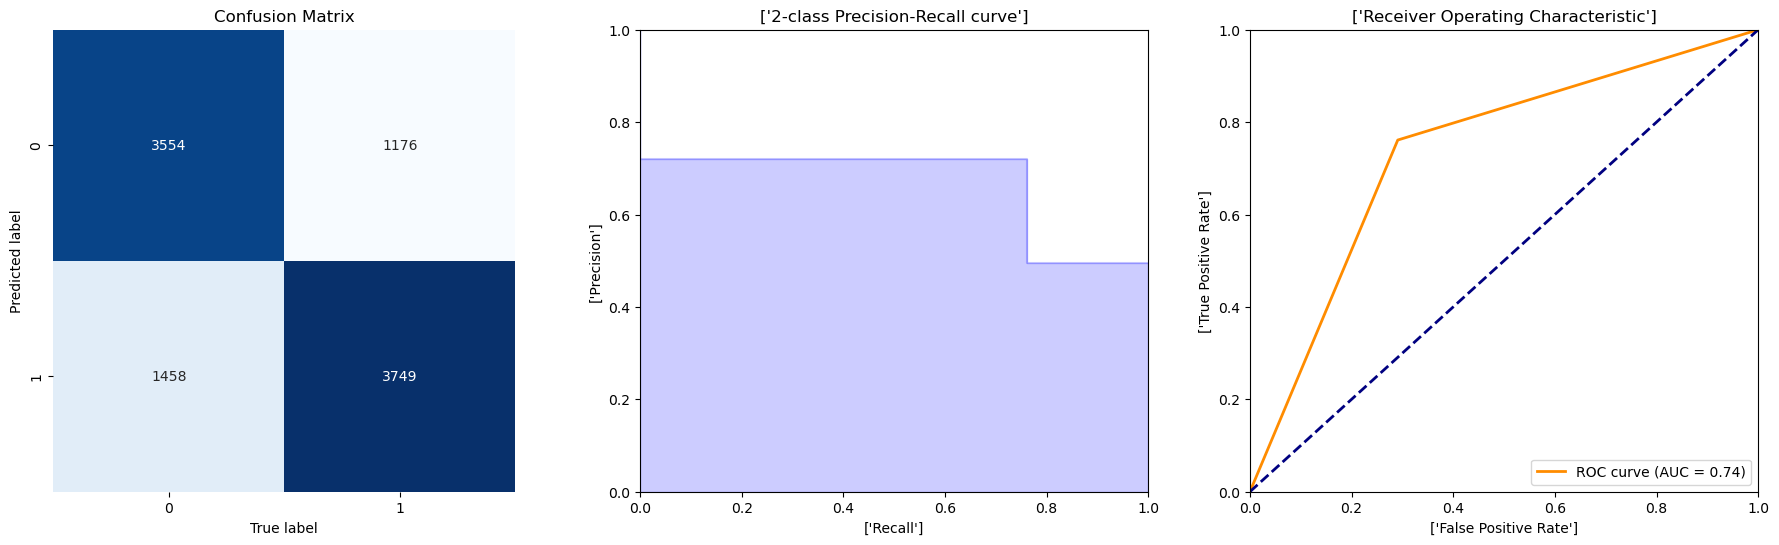

In [13]:
show_summary_report(y_test, y_pred_cvec, y_prob_cvec)

In [17]:
# bigram bow count vec
cvec_bigram = CountVectorizer(token_pattern = r'\w{1,}', ngram_range=(1, 2), max_features=1000)
cvec_bigram.fit(data['text_stem'])

X_train_cvec2 = cvec_bigram.transform(X_train)
X_test_cvec2 = cvec_bigram.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_cvec2, y_train)

y_pred_cvec2 = nb_model.predict(X_test_cvec2)
y_prob_cvec2 = nb_model.predict_proba(X_test_cvec2)

scores_dict['NB bigram bow'] = round(accuracy_score(y_test, y_pred_cvec2), 2)

In [18]:
# visualisation of df of countvec 
# pd.DataFrame(X_train_cvec_bigram.todense(), columns=cvec.get_feature_names_out()).head()

Accuracy : 0.7309 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7146 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7610 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7312      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


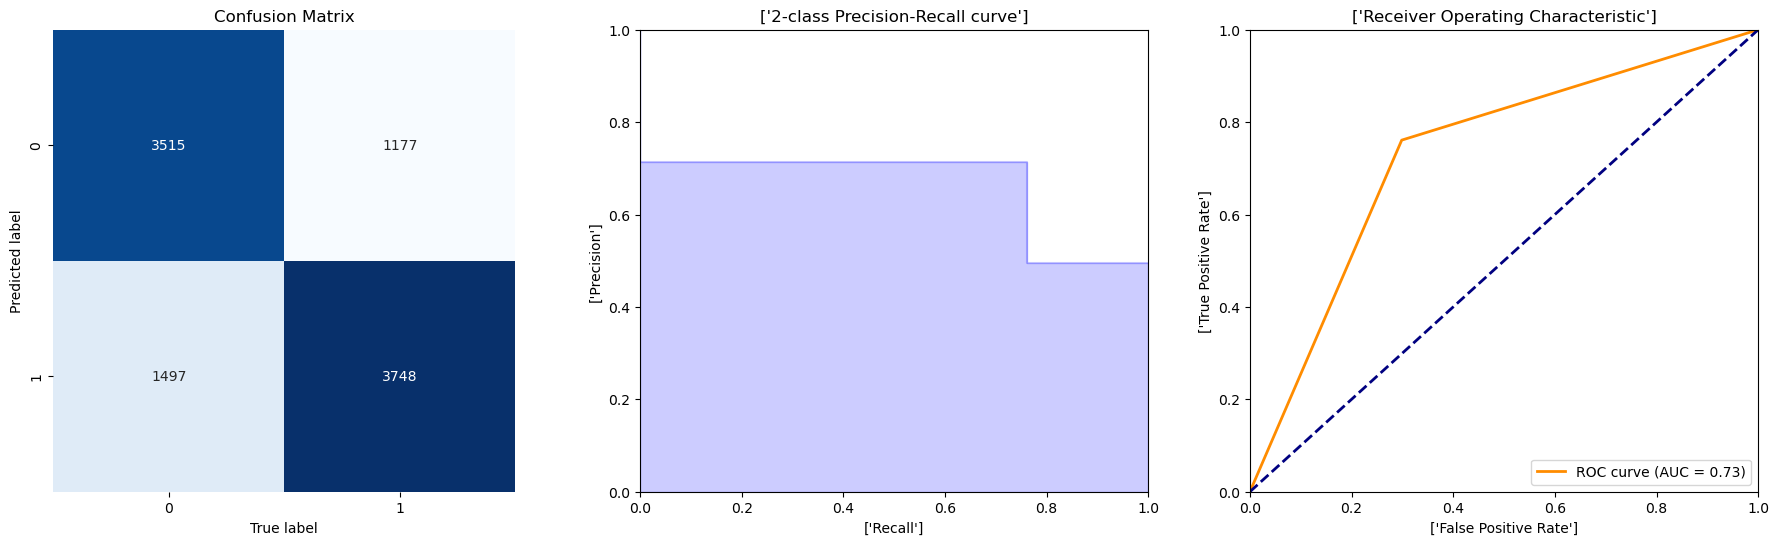

In [19]:
show_summary_report(y_test, y_pred_cvec2, y_prob_cvec2)

In [20]:
# trigram bow count vec
cvec_trigram = CountVectorizer(token_pattern = r'\w{1,}', ngram_range=(1, 3), max_features=1000)
cvec_trigram.fit(data['text_stem'])

X_train_cvec3 = cvec_trigram.transform(X_train)
X_test_cvec3 = cvec_trigram.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_cvec3, y_train)

y_pred_cvec3 = nb_model.predict(X_test_cvec3)
y_prob_cvec3 = nb_model.predict_proba(X_test_cvec3)

scores_dict['NB trigram bow'] = round(accuracy_score(y_test, y_pred_cvec3), 2)

In [21]:
# visualisation of df of countvec 
# pd.DataFrame(X_train_cvec_trigram.todense(), columns=cvec.get_feature_names_out()).head()

Accuracy : 0.7311 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7144 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7622 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7314      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


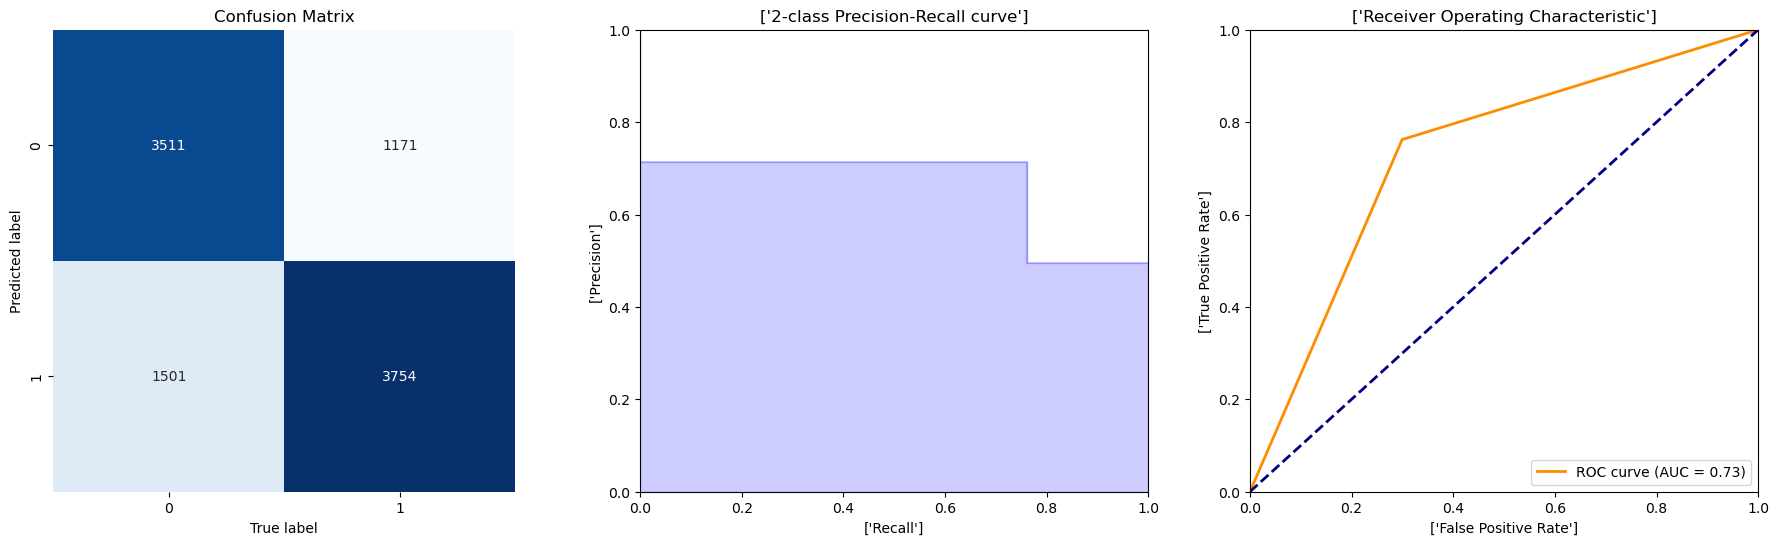

In [40]:
show_summary_report(y_test, y_pred_cvec3, y_prob_cvec3)

### TFIDF

In [41]:
# unigram tfidf
tfidf = TfidfVectorizer(analyzer = 'word', max_features = 1000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print (X_train_tfidf.shape, X_test_tfidf.shape)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_tfidf = nb_model.predict(X_test_tfidf)
y_prob_tfidf = nb_model.predict_proba(X_test_tfidf)

scores_dict['NB tfidf'] = round(accuracy_score(y_test, y_pred_tfidf), 2)

(39745, 1000) (9937, 1000)


Accuracy : 0.7290 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7123 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7602 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7293      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


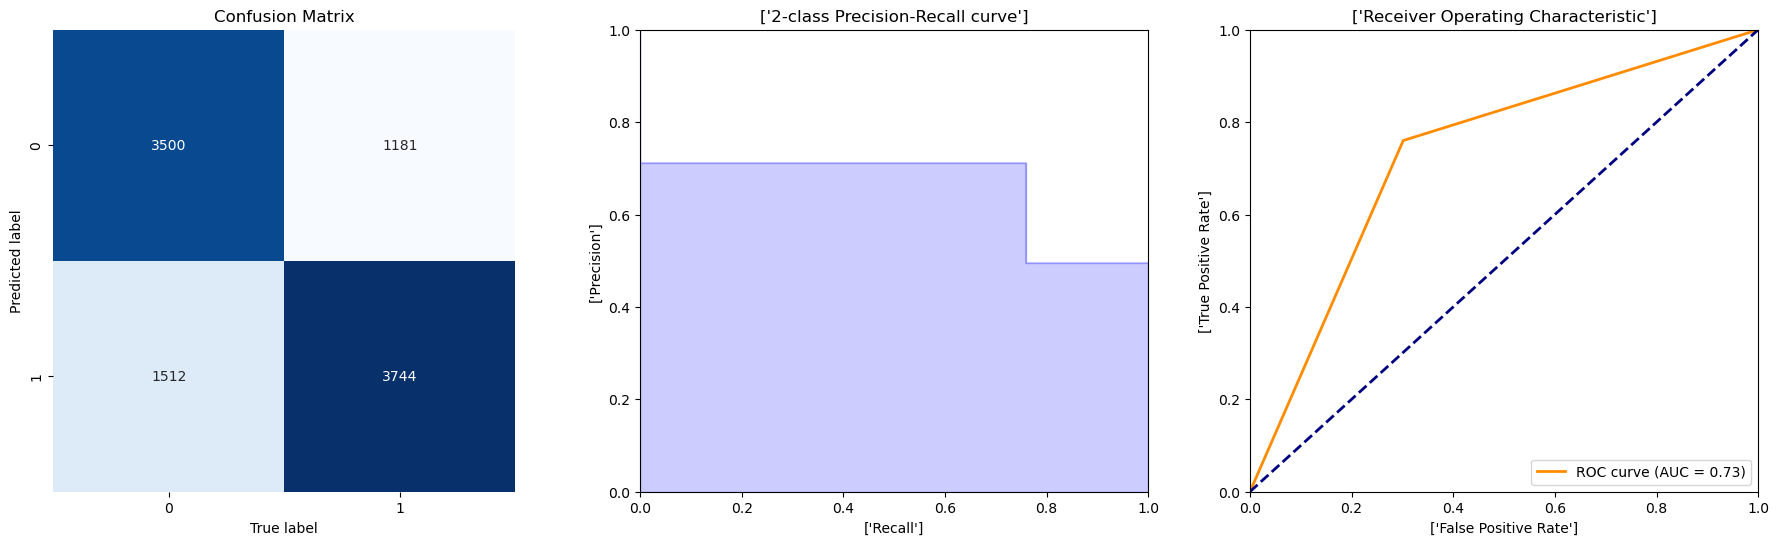

In [42]:
show_summary_report(y_test, y_pred_tfidf, y_prob_tfidf)

In [43]:
# bigram tfidf
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range=(1,2), max_features = 1000)

X_train_tfidf2 = tfidf.fit_transform(X_train)
X_test_tfidf2 = tfidf.transform(X_test)
print (X_train_tfidf2.shape, X_test_tfidf2.shape)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf2, y_train)

y_pred_tfidf2 = nb_model.predict(X_test_tfidf2)
y_prob_tfidf2 = nb_model.predict_proba(X_test_tfidf2)

scores_dict['NB bigram tfidf'] = round(accuracy_score(y_test, y_pred_tfidf2), 2)

(39745, 1000) (9937, 1000)


Accuracy : 0.7271 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7092 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7616 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7274      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


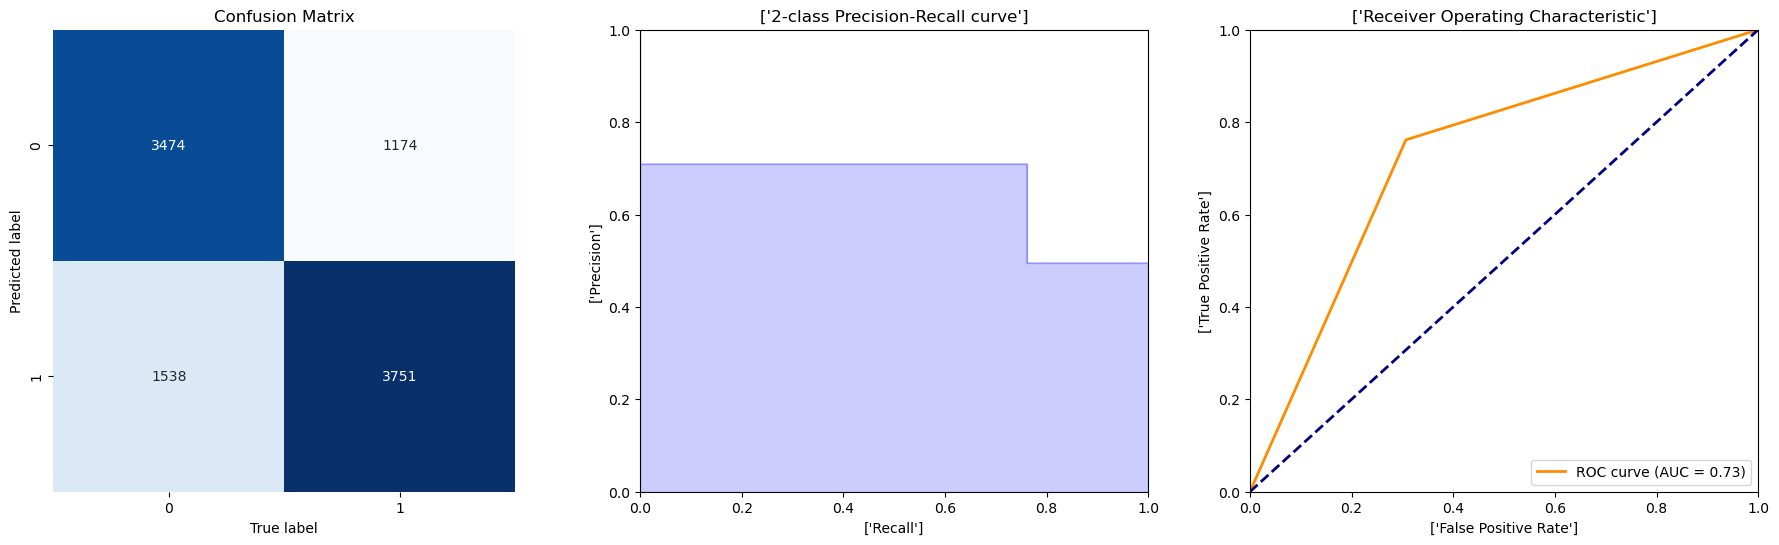

In [44]:
show_summary_report(y_test, y_pred_tfidf2, y_prob_tfidf2)

In [45]:
# trigram tfidf
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range=(1,3), max_features = 1000)

X_train_tfidf3 = tfidf.fit_transform(X_train)
X_test_tfidf3 = tfidf.transform(X_test)
print (X_train_tfidf3.shape, X_test_tfidf3.shape)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf3, y_train)

y_pred_tfidf3 = nb_model.predict(X_test_tfidf3)
y_prob_tfidf3 = nb_model.predict_proba(X_test_tfidf3)

scores_dict['NB trigram tfidf'] = round(accuracy_score(y_test, y_pred_tfidf3), 2)

(39745, 1000) (9937, 1000)


Accuracy : 0.7269 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7086 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7624 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7272      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


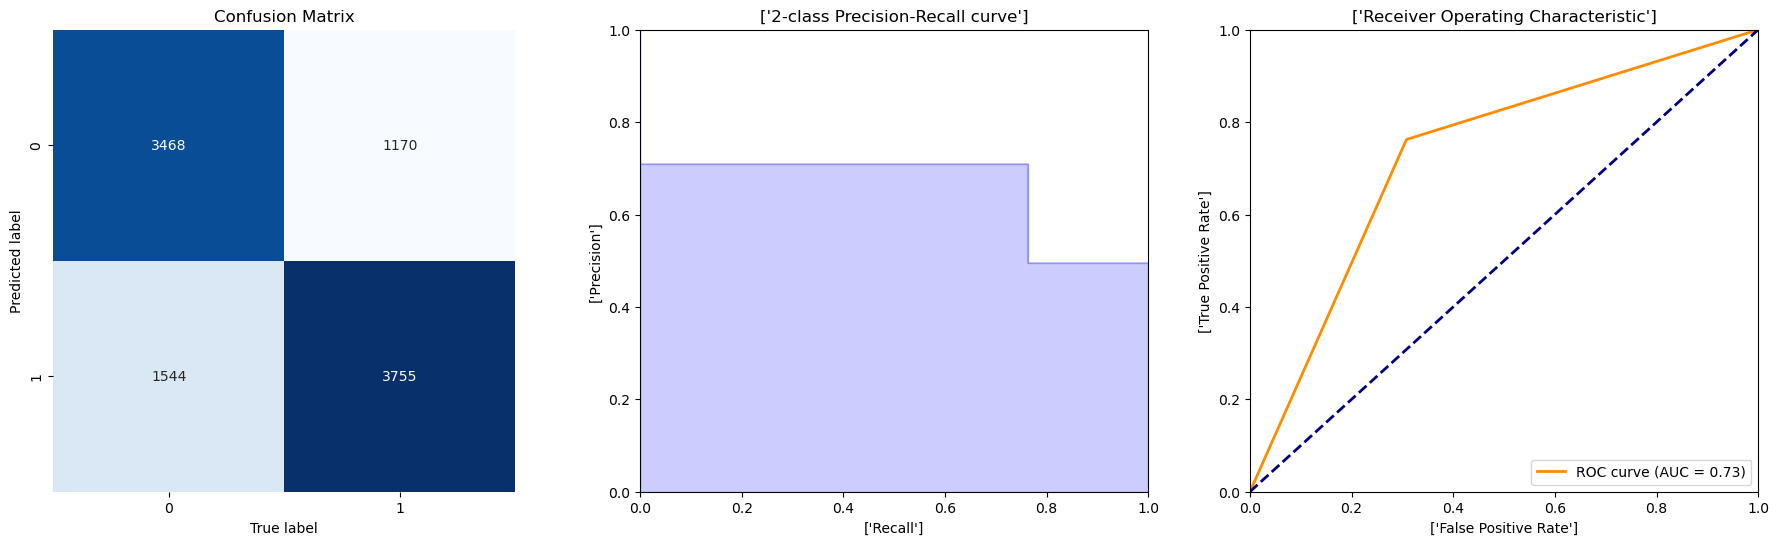

In [46]:
show_summary_report(y_test, y_pred_tfidf3, y_prob_tfidf3)

In [22]:
features_sum = {'Accuracy': [0.73, 0.73, 0.73, 0.73, 0.73, 0.73],
                    'Precision': [0.72, 0.71, 0.71, 0.74, 0.71, 0.71], 
                    'Recall': [0.76, 0.76, 0.76, 0.76, 0.76, 0.76], 
                    'ROC': [0.74, 0.73, 0.73, 0.73, 0.73, 0.73]}
features_summary = pd.DataFrame(features_sum, index=['bow', 'bow_bgiram', 'bow_trigram',
                                                    'tdidf', 'tfidf_bigram', 'tfidf_trigram'])
features_summary

,Accuracy,Precision,Recall,ROC
bow,0.73,0.72,0.76,0.74
bow_bgiram,0.73,0.71,0.76,0.73
bow_trigram,0.73,0.71,0.76,0.73
tdidf,0.73,0.74,0.76,0.73
tfidf_bigram,0.73,0.71,0.76,0.73
tfidf_trigram,0.73,0.71,0.76,0.73


In [48]:
scores_dict

{'NB cvec': 0.73,
 'NB bigram cvec': 0.73,
 'NB trigram cvec': 0.73,
 'NB tfidf': 0.73,
 'NB bigram tfidf': 0.73,
 'NB trigram tfidf': 0.73}

### BOW model nd explore other ML model

In [14]:
# nb + single count vec with more features fitted
cvec = CountVectorizer(token_pattern = r'\w{1,}', max_features=5000)
cvec.fit(data['text_stem'])

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [24]:
# visualisation of df of countvec 
dfcount = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names_out())
dfcount

,aaa,aaaa,aaaaaa,aah,aaron,abandoned,abbr,abc,ability,able,...,zac,zach,zealand,zero,zip,zoe,zombie,zone,zoo,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# intialise model
nb_model = MultinomialNB()
nb_model.fit(X_train_cvec, y_train)

y_pred_nb = nb_model.predict(X_test_cvec)
y_prob_nb = nb_model.predict_proba(X_test_cvec)

print('Accuracy:', round(accuracy_score(y_test, y_pred_nb), 2))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5012
           1       0.74      0.75      0.74      4925

    accuracy                           0.75      9937
   macro avg       0.75      0.75      0.75      9937
weighted avg       0.75      0.75      0.75      9937



In [26]:
# define params
params ={
    'alpha' : [0.01, 0.1, 1.0, 10, 100]
}

In [28]:
# search for best params
nb_gs = GridSearchCV(MultinomialNB(), params, 
                     scoring='accuracy', cv=10)
nb_gs.fit(X_train_cvec, y_train)

# best params: 
print(nb_gs.best_params_)
print(nb_gs.best_score_)

{'alpha': 10}
0.7422063918615656


In [29]:
# fit best params
nb_model = MultinomialNB(alpha=10)
nb_model.fit(X_train_cvec, y_train)

# make predictions
y_pred = nb_model.predict(X_test_cvec)
y_prob = nb_model.predict_proba(X_test_cvec)

Accuracy : 0.7482 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7459 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7462 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7482      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


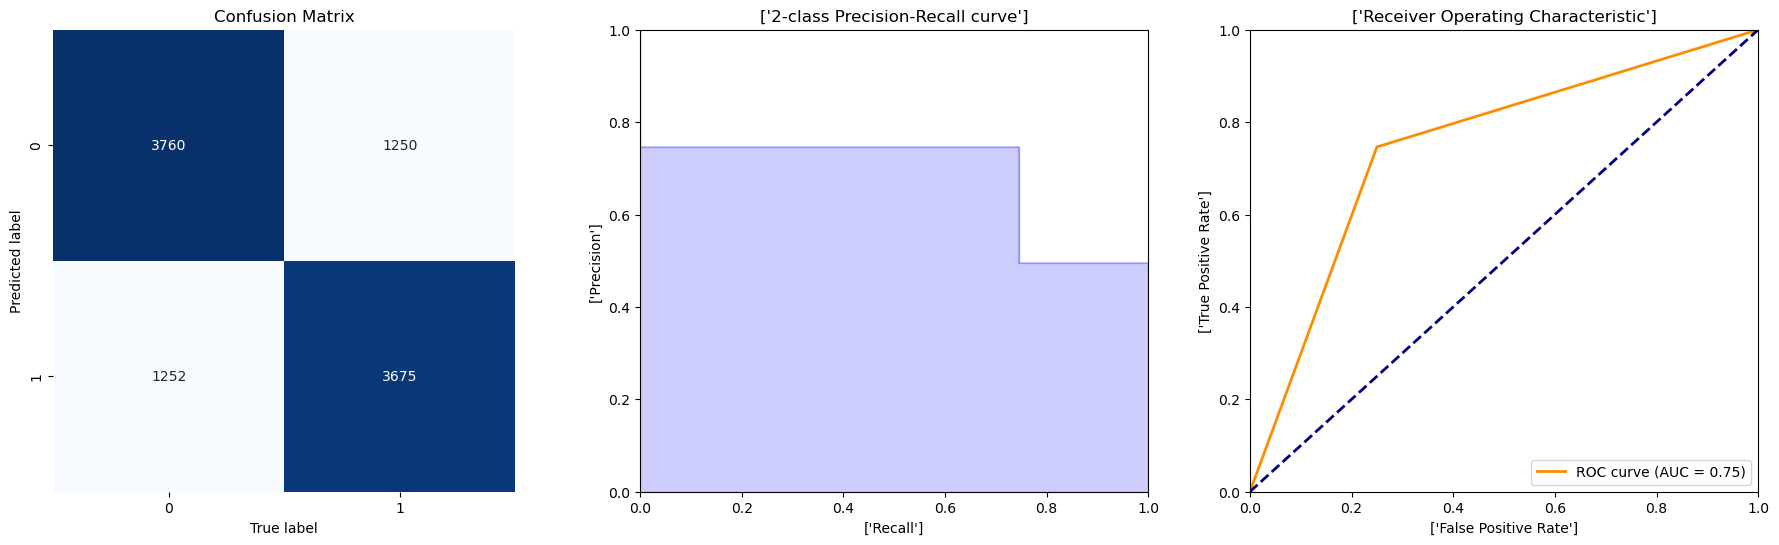

In [30]:
show_summary_report(y_test, y_pred, y_prob)

In [32]:
# collate results of best model chose (counvec)
# tuning it did not change matrixes  
model_dict = {'BOW Model':['Naive Bayes'],
              'Accuracy':[0.75],
              'Precision': [0.75],
              'Recall':[0.75],
              'ROC':[0.75]
             }
cvec_results = pd.DataFrame(model_dict).set_index('BOW Model')
cvec_results

,Accuracy,Precision,Recall,ROC
BOW Model,,,,
Naive Bayes,0.75,0.75,0.75,0.75


In [15]:
# try logreg
lr_model = LogisticRegression(max_iter=100000)
lr_model.fit(X_train_cvec, y_train)

y_pred_lr = lr_model.predict(X_test_cvec)
y_prob_lr = lr_model.predict_proba(X_test_cvec)

print('Accuracy:', round(accuracy_score(y_test, y_pred_lr), 2))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5012
           1       0.74      0.77      0.75      4925

    accuracy                           0.75      9937
   macro avg       0.75      0.75      0.75      9937
weighted avg       0.75      0.75      0.75      9937



In [18]:
#y_prob_lr = lr_model.predict_proba(X_test_cvec)[:,1]

In [19]:
#precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)
# Use AUC function to calculate the area under the curve of precision recall curve
#auc_precision_recall = auc(recall, precision)
#print(auc_precision_recall)

0.7971515679625599


Accuracy : 0.7504 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7358 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7746 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7506      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


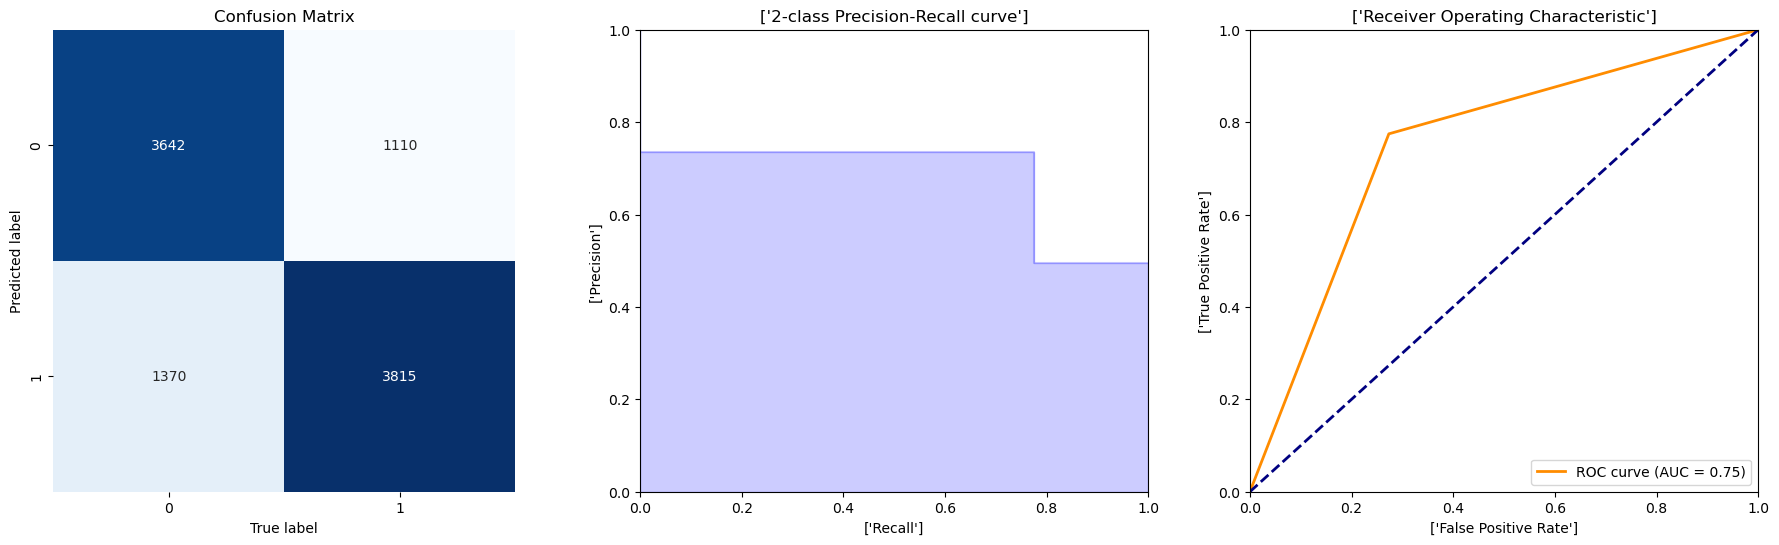

In [34]:
show_summary_report(y_test, y_pred_lr, y_prob_lr)

In [35]:
# add accuracy, precision, recall & ROC of logreg model
cvec_results.loc['Logistic Regression'] = [0.75, 0.74, 0.77, 0.75]

In [36]:
cvec_results

,Accuracy,Precision,Recall,ROC
BOW Model,,,,
Naive Bayes,0.75,0.75,0.75,0.75
Logistic Regression,0.75,0.74,0.77,0.75


In [37]:
# random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_cvec, y_train)

y_pred_rf = rf_model.predict(X_test_cvec)
y_prob_rf = rf_model.predict_proba(X_test_cvec)

print('Accuracy:', round(accuracy_score(y_test, y_pred_rf), 2))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      5012
           1       0.73      0.73      0.73      4925

    accuracy                           0.73      9937
   macro avg       0.73      0.73      0.73      9937
weighted avg       0.73      0.73      0.73      9937



In [38]:
# define params
params ={
    'n_estimators' : [10,20,40,80,100],
    'max_features': [6,12,32]
    #'max_depth': [],
    
}

In [39]:
rf_gs = GridSearchCV(RandomForestClassifier(), params, 
                     scoring='accuracy', cv=10)
rf_gs.fit(X_train_cvec, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': [6, 12, 32],
                         'n_estimators': [10, 20, 40, 80, 100]},
             scoring='accuracy')

In [40]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'max_features': 6, 'n_estimators': 80}
0.7300032032108074


In [41]:
# fit with best params found
rf_model = RandomForestClassifier(n_estimators=80, 
                                  max_features=6,
                                 random_state=42)
rf_model.fit(X_train_cvec, y_train)

y_pred_rf = rf_model.predict(X_test_cvec)
y_prob_rf = rf_model.predict_proba(X_test_cvec)

Accuracy : 0.7447 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7316 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7659 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC : 0.7449      Best: 1, Worst: <0.5
-----------------------------------------------------------------------------------------------------------


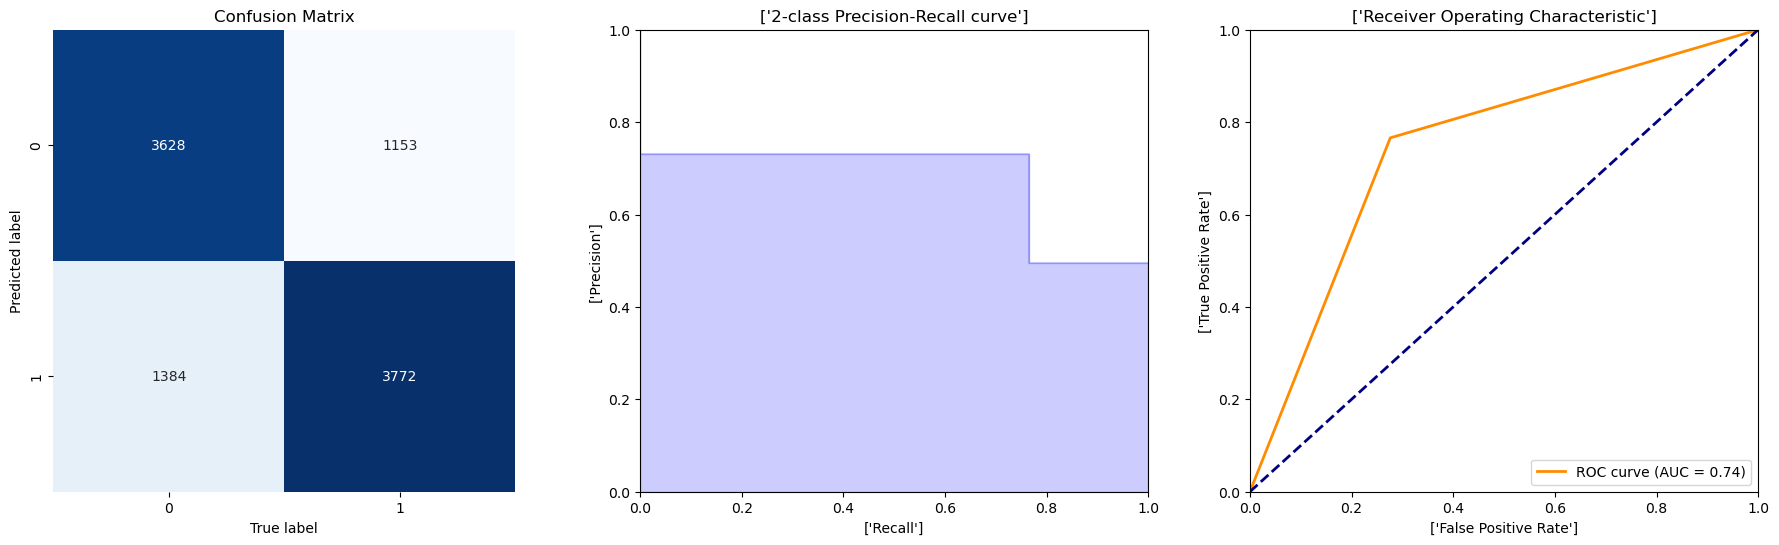

In [42]:
show_summary_report(y_test, y_pred_rf, y_prob_rf)

In [43]:
# add accuracy, precision, recall & ROC of RF model
cvec_results.loc['Random Forest'] = [0.74, 0.73, 0.77, 0.74]

In [44]:
cvec_results

,Accuracy,Precision,Recall,ROC
BOW Model,,,,
Naive Bayes,0.75,0.75,0.75,0.75
Logistic Regression,0.75,0.74,0.77,0.75
Random Forest,0.74,0.73,0.77,0.74


### Predict with new data on trained model

In [45]:
sb = pd.read_csv('../projects/sblabelled.csv')

In [46]:
# processed and SIA-labelled starbucks data 
sb

,text_str,sentiment_score,Sentiment,SIA_label
0,shooters lucida guy also commission starbucks ...,-0.4404,Negative,-1
1,fumbled hard hire please hire,0.2263,Positive,1
2,somebody probably told starbucks drive thru mi...,-0.3400,Negative,-1
3,jungles red tape keys truck vent starbucks cup...,0.0000,Neutral,0
4,cryptolab x dalgomz x starbucks try airdrop ev...,0.0000,Neutral,0
5,solidarity partners hwy amp brinkley hill star...,0.2960,Positive,1
6,starbucks customize journey set,0.0000,Neutral,0
7,skip starbucks today join instead give dick love,0.4767,Positive,1
8,nervous apply job like barnstar store glasgow ...,0.4215,Positive,1
9,true di ako ready miya sa starbucks ng med city,0.6486,Positive,1


In [47]:
sb1 = sb[['Sentiment', 'text_str']]
label_counts = sb1.groupby('Sentiment').count()
label_counts

,text_str
Sentiment,
Negative,7
Neutral,15
Positive,21


Text(0, 0.5, 'Count')

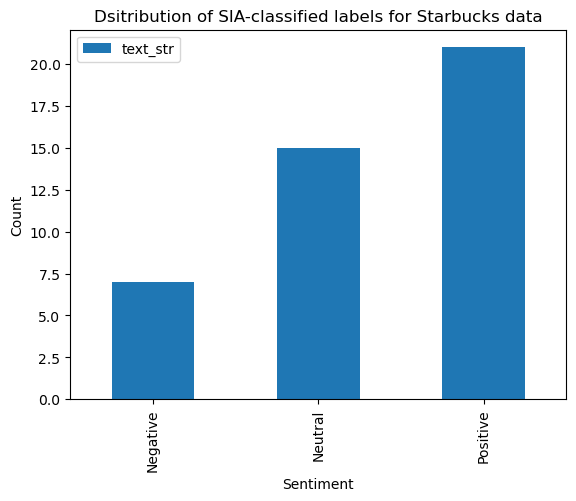

In [48]:
label_counts.plot(kind='bar')
plt.title('Dsitribution of SIA-classified labels for Starbucks data')
plt.ylabel('Count')

In [49]:
# convert new data into numerical features with vectorizer used to convert original data 
new_data_vectorized = cvec.transform(sb['text_str'].values.flatten())

In [50]:
predictions = lr_model.predict(new_data_vectorized)
predictions

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
      dtype=int64)

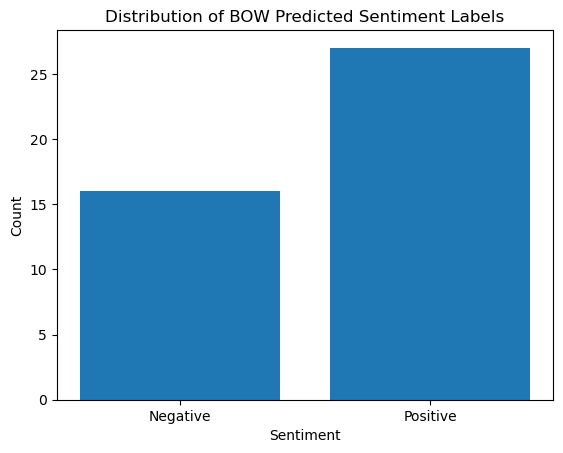

In [51]:
# get count of each predicted label
unique_labels, counts = np.unique(predictions, return_counts=True)

# plot bar chart for visualisations
plt.bar(unique_labels, counts)
plt.xticks(unique_labels, ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of BOW Predicted Sentiment Labels')
plt.show()

In [69]:
# trial to get in a df
X_new = cvec.transform(sb['text_str'])
y_pred = lr_model.predict(X_new)

# create df of predicted labels
df_pred = pd.DataFrame({'text_str': sb['text_str'], 'predicted_label': y_pred})

In [70]:
df_pred['predicted_sentiment']=''
df_pred.loc[df_pred['predicted_label']==0, 'predicted_sentiment']='Negative'
df_pred.loc[df_pred['predicted_label']==1, 'predicted_sentiment']='Positive'

In [71]:
df_pred

,text_str,predicted_label,predicted_sentiment
0,shooters lucida guy also commission starbucks ...,0,Negative
1,fumbled hard hire please hire,1,Positive
2,somebody probably told starbucks drive thru mi...,0,Negative
3,jungles red tape keys truck vent starbucks cup...,0,Negative
4,cryptolab x dalgomz x starbucks try airdrop ev...,1,Positive
5,solidarity partners hwy amp brinkley hill star...,1,Positive
6,starbucks customize journey set,0,Negative
7,skip starbucks today join instead give dick love,1,Positive
8,nervous apply job like barnstar store glasgow ...,0,Negative
9,true di ako ready miya sa starbucks ng med city,1,Positive


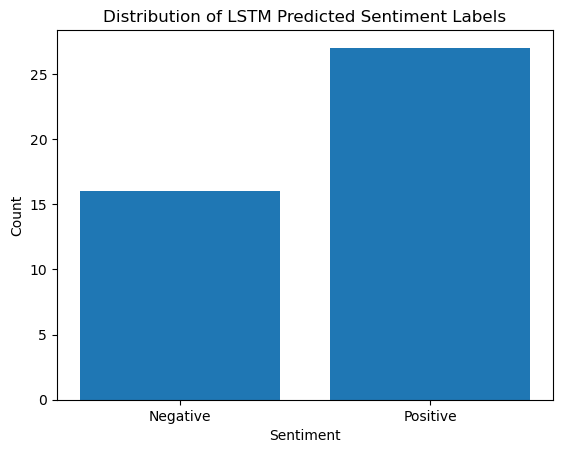

In [72]:
# get count of each predicted label
unique_labels, counts = np.unique(df_pred['predicted_label'], return_counts=True)

# plot bar chart for visualisations
plt.bar(unique_labels, counts)
plt.xticks(unique_labels, ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of LSTM Predicted Sentiment Labels')
plt.show()

In [73]:
total_df = pd.merge(df_pred,sb,on='text_str')
total_df

,text_str,predicted_label,predicted_sentiment,sentiment_score,Sentiment,SIA_label
0,shooters lucida guy also commission starbucks ...,0,Negative,-0.4404,Negative,-1
1,fumbled hard hire please hire,1,Positive,0.2263,Positive,1
2,somebody probably told starbucks drive thru mi...,0,Negative,-0.3400,Negative,-1
3,jungles red tape keys truck vent starbucks cup...,0,Negative,0.0000,Neutral,0
4,cryptolab x dalgomz x starbucks try airdrop ev...,1,Positive,0.0000,Neutral,0
5,solidarity partners hwy amp brinkley hill star...,1,Positive,0.2960,Positive,1
6,starbucks customize journey set,0,Negative,0.0000,Neutral,0
7,skip starbucks today join instead give dick love,1,Positive,0.4767,Positive,1
8,nervous apply job like barnstar store glasgow ...,0,Negative,0.4215,Positive,1
9,true di ako ready miya sa starbucks ng med city,1,Positive,0.6486,Positive,1


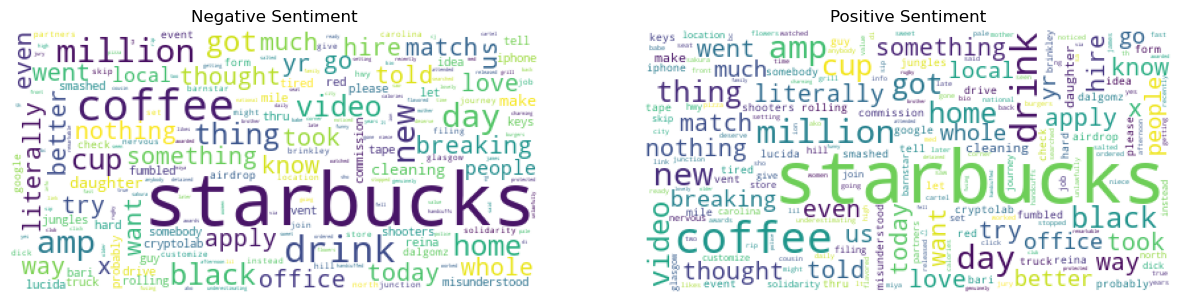

In [76]:
# Get most common words in predicted sentiment label

data_neg = total_df[total_df.predicted_label==0]
neg_words = ' '.join([word for word in total_df['text_str']])
data_pos = total_df[total_df.predicted_label==1]
pos_words = ' '.join([word for word in total_df['text_str']])

# Create word clouds
pos_cloud = WordCloud(background_color='white').generate(pos_words)
neg_cloud = WordCloud(background_color='white').generate(neg_words)

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(neg_cloud)
axes[0].set_title('Negative Sentiment')
axes[0].axis('off')
axes[1].imshow(pos_cloud)
axes[1].set_title('Positive Sentiment')
axes[1].axis('off')
plt.show()